In [14]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from preprocessor import AdvancedTextPreprocessor
warnings.filterwarnings('ignore')
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

Обучение модели...
F1-Score (spam): 0.9324
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.88      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



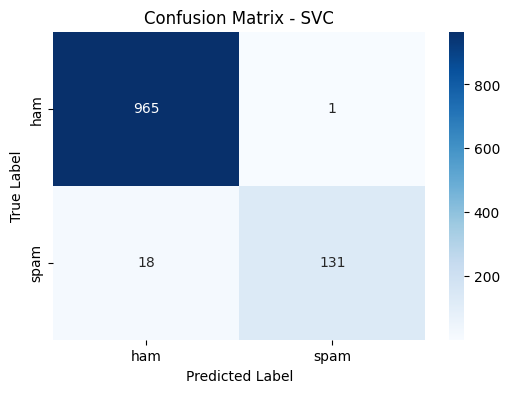

Модель, векторизатор и препроцессор успешно сохранены в один файл!
Демонстрация работы модели:
Сообщение: Free entry in 2 a wkly comp to win FA Cup final tkts
Предсказание: spam
Вероятность спама: 0.9219
Вероятность не спама: 0.0781
Обработанный текст: free entri wkli comp win cup final tkt
--------------------------------------------------
Сообщение: Hey, are we still meeting for lunch tomorrow?
Предсказание: ham
Вероятность спама: 0.0007
Вероятность не спама: 0.9993
Обработанный текст: hey still meet lunch tomorrow
--------------------------------------------------
Сообщение: Congratulations! You've won a $1000 gift card. Click here to claim.
Предсказание: spam
Вероятность спама: 0.9092
Вероятность не спама: 0.0908
Обработанный текст: congratul 've 1000 gift card click claim
--------------------------------------------------
Сообщение: Ok, see you later then
Предсказание: ham
Вероятность спама: 0.0005
Вероятность не спама: 0.9995
Обработанный текст: see later
------------------------

In [15]:
# Загрузка данных
def load_data(filepath):
    df = pd.read_csv(filepath, encoding='latin-1')
    df = df.rename(columns={'v1': 'target', 'v2': 'text'})
    df = df[['target', 'text']]
    return df

# Функция для обучения и сохранения модели
def train_and_save_model():
    # Загрузка данных
    df = load_data('spam.zip')
    
    # Препроцессинг
    preprocessor = AdvancedTextPreprocessor()
    df['processed_text'] = df['text'].apply(preprocessor.preprocess)
    
    X = df['processed_text']
    y = df['target']
    
    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Векторизация
    vectorizer = TfidfVectorizer(
        max_features=3000, min_df=2, max_df=0.8,
        ngram_range=(1, 3)
    )
    
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
    # Обучение модели
    model = SVC(random_state=42, probability=True)
    model.fit(X_train_vectorized, y_train)
    
    # Оценка модели
    y_pred = model.predict(X_test_vectorized)
    f1 = f1_score(y_test, y_pred, pos_label='spam')
    
    print(f"F1-Score (spam): {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Визуализация матрицы ошибок
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['ham', 'spam'], 
                yticklabels=['ham', 'spam'])
    plt.title('Confusion Matrix - SVC')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    # Сохранение модели, векторизатора и препроцессора в ОДИН файл
    model_data = {
        'model': model,
        'vectorizer': vectorizer,
        'preprocessor': preprocessor
    }
    joblib.dump(model_data, 'spam_classifier.joblib')
    
    print("Модель, векторизатор и препроцессор успешно сохранены в один файл!")
    
    return model, vectorizer, preprocessor

# Функция для загрузки модели и предсказания
def load_model_and_predict(message):
    # Загрузка ОДНОГО файла с моделью, векторизатором и препроцессором
    try:
        model_data = joblib.load('spam_classifier.joblib')
        model = model_data['model']
        vectorizer = model_data['vectorizer']
        preprocessor = model_data['preprocessor']
    except FileNotFoundError:
        print("Файл модели не найден. Сначала обучите модель.")
        return None

    # Предобработка и предсказание
    processed_text = preprocessor.preprocess(message)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]
    probability = model.predict_proba(vectorized_text)[0]
    
    result = {
        'prediction': prediction,
        'spam_probability': probability[1] if model.classes_[1] == 'spam' else probability[0],
        'ham_probability': probability[0] if model.classes_[0] == 'ham' else probability[1],
        'processed_text': processed_text
    }
    
    return result

# Функция для демонстрации работы модели
def demo_predictions():
    test_messages = [
        "Free entry in 2 a wkly comp to win FA Cup final tkts",
        "Hey, are we still meeting for lunch tomorrow?",
        "Congratulations! You've won a $1000 gift card. Click here to claim.",
        "Ok, see you later then",
        "URGENT: Your bank account has been suspended. Verify your details now."
    ]
    
    print("Демонстрация работы модели:")
    print("=" * 50)
    
    for msg in test_messages:
        result = load_model_and_predict(msg)
        if result:
            print(f"Сообщение: {msg}")
            print(f"Предсказание: {result['prediction']}")
            print(f"Вероятность спама: {result['spam_probability']:.4f}")
            print(f"Вероятность не спама: {result['ham_probability']:.4f}")
            print(f"Обработанный текст: {result['processed_text']}")
            print("-" * 50)

# Основная функция
if __name__ == "__main__":
    # Обучаем и сохраняем модель (раскомментируйте для обучения)
    print("Обучение модели...")
    model, vectorizer, preprocessor = train_and_save_model()
    
    # Демонстрация работы модели
    demo_predictions()
    
    # Пример использования для одного сообщения
    test_message = "Free money! Claim your prize now!"
    result = load_model_and_predict(test_message)
    
    if result:
        print(f"\nРезультат для тестового сообщения:")
        print(f"Сообщение: {test_message}")
        print(f"Предсказание: {result['prediction']}")
        print(f"Вероятность спама: {result['spam_probability']:.4f}")
        print(f"Вероятность не спама: {result['ham_probability']:.4f}")